In [120]:
import csv
import json
import re, os
import time
from datetime import datetime
import copy

dep_id = '9212022'
reward_data_file_path = '../../data/{}/reward_data.csv'.format(dep_id)
reward_data_clean_file_path = '../../data/{}/reward_data_clean_with_speakerid.csv'.format(dep_id)

deployment_date_info = {
    "6092021": ["2021-06-09 00:00:00", "2021-11-13 11:59:59"],
    "7132021": ["2021-07-13 00:00:00", "2021-12-03 11:59:59"],
    "8022021": ["2021-08-02 00:00:00", "2021-12-07 11:59:59"],
    # "10282021": ["2021-10-28 00:00:00", ""],
    "1172022": ["2022-01-17 00:00:00", "2022-06-02 23:59:59"],
    "2182022": ["2022-02-18 00:00:00", "2022-06-15 23:59:59"],
    "3162022": ["2022-03-16 00:00:00", "2022-07-06 23:59:59"],
    # "5062022": ["2022-05-06 00:00:00", ""],
    "5122022": ["2022-05-12 00:00:00", "2022-05-31 23:59:59"],      # This is the baseline period of 9212022
    # "8122022": ["2022-08-12 00:00:00", ""],
    "9152022": ["2022-09-15 00:00:00", "2023-02-06 23:59:59"],
    "9212022": ["2022-09-21 00:00:00", "2023-01-05 23:59:59"],
    # "11192022": ["2022-11-09 00:00:00", ""],
    "1182023": ["2023-01-18 00:00:00", "2023-04-05 23:59:59"],
    "5302023": ["2023-05-30 00:00:00", "2023-09-26 23:59:59"]
}

### Read Reward Data

The saved files of reward_data contains 10 fields:
* TimeSent, TimeReceived', Response, Question, QuestionType, QuestionName, Reactive, SentTimes, ConnectionError, dep_id

In [121]:
## Remove Duplication
with open(reward_data_file_path, newline='') as f:
    with open(reward_data_clean_file_path, 'w') as f_out:
        reward_data_reader = csv.reader(f)
        cnt_line = 0
        prev_line_timesent = None
        prev_line = None
        start_date = deployment_date_info[dep_id][0]
        end_date = deployment_date_info[dep_id][1] if deployment_date_info[dep_id][1] != "" else None
        start_date = datetime.fromisoformat(start_date)
        end_date = datetime.fromisoformat(end_date) if end_date is not None else None

        for line in reward_data_reader:
            cnt_line += 1                           # line 0 represents the head line
            if cnt_line > 1:

                # only select data during the real deployment period
                t = datetime.fromisoformat(line[1])
                if end_date:
                    if start_date > t or t > end_date:
                        continue
                else:
                    if start_date > t:
                        continue

                if prev_line_timesent is not None and line[1] == prev_line_timesent:
                    # The current line has the same SentTime as the previous line
                    try:
                        # If this line is same as the previous line, we skip it
                        assert line[0] == prev_line[0]      # speakerID
                        assert line[3] == prev_line[3]      # Response 
                        assert line[4] == prev_line[4]      # Question
                        assert line[5] == prev_line[5]      # Question Type
                        assert line[6] == prev_line[6]      # Question Name
                        assert line[7] == prev_line[7]      # Reactive
                        assert line[8] == prev_line[8]      # SentTimes
                        assert line[9] == prev_line[9]      # ConnectionError
                        assert line[10] == prev_line[10]    # dep-id

                    except:
                        # Otherwise, we still save it into the file
                        print(cnt_line, line)
                        # write this line to the new file
                        f_out.write(','.join([
                            line[0], line[1], line[2], '"'+line[3]+'"', '"'+line[4]+'"',
                            line[5], line[6], line[7], line[8], line[9], line[10]
                            ])
                        )
                        f_out.write('\n')

                    continue

                else:
                    # write this line to the new file
                    f_out.write(','.join([
                        line[0], line[1], line[2], '"'+line[3]+'"', '"'+line[4]+'"',
                        line[5], line[6], line[7], line[8], line[9], line[10]
                        ])
                    )
                    f_out.write('\n')
            else:
                # write the first line (i.e. header) into the file
                f_out.write(','.join(line))
                f_out.write('\n')
            prev_line_timesent = line[1]
            prev_line = copy.deepcopy(line)

185 ['9', '2022-10-02 17:10:24', '0000-00-00 00:00:00.', '-1.0', 'If you are experiencing a stressful situation, please click on the button below! ', 'radio', 'request:button:1', '0', '1', '0', '9212022']
321 ['0', '2022-10-06 16:15:27', '2022-10-06 16:29:16', '2', 'It seems like you and Caregivee may be experiencing a stressful situation about 15 minutes ago. ', 'radio', 'daytime:check_in:reactive:1', '1', '3', '0', '9212022']
1123 ['1', '2022-10-26 10:37:41', '2022-10-26 10:46:25', '3', 'It seems like you and Caregivee may be experiencing a stressful situation about 5 minutes ago. ', 'radio', 'daytime:check_in:reactive:1', '1', '2', '0', '9212022']
1624 ['9', '2022-11-10 11:47:48', '0000-00-00 00:00:00.', '-1.0', 'If you are experiencing a stressful situation, please click on the button below! ', 'radio', 'request:button:1', '0', '1', '0', '9212022']
2064 ['9', '2022-12-01 10:18:23', '2022-12-01 10:33:20', '0', 'Setting your Self-Care Goal:Remember that while you are providing care f

In [122]:
baseline_period_end_line = 0
with open(reward_data_clean_file_path, newline='') as f_clean:
    print("read file: ", reward_data_clean_file_path)
    reward_data_reader = csv.reader(f_clean)
    cnt_line = 0
    # Get the end line of the baseline period
    for line in reward_data_reader:
            cnt_line += 1                           # line 0 represents the head line
            if cnt_line > 1:
                question_name = line[6]
                if 'baseline' in question_name:
                    baseline_period_end_line = cnt_line
                if 'daytime' in question_name and 'baseline' not in question_name:
                    # Some of the depolyments moved into the intervention period incorrectly
                    # and swithced back to the baseline period at the start of the development.
                    if cnt_line >= 100:
                        break

    print('baseline period ends at line: {}'.format(baseline_period_end_line))

read file:  ../../data/9212022/reward_data_clean_with_speakerid.csv
baseline period ends at line: 184


In [123]:
class RecommMessage():
    def __init__(
        self,
        message_type='',        # Message Type (str), can only be 'proactive', 'reactive', and 'request'
        start_line=-1,
        end_line=-1
    ):
        self.message_type = message_type
        self.start_line = start_line
        self.end_line = end_line

        # check-in (including click the request button)
        self.checkin_send = False           # whether we send the check-in msg
        self.checkin_response = False       # whether we receive the response for the check-in msg
        self.checkin_sendtimes = 0          # initialize the number of times of sending check-in msg to be 0

        # recommendation tips (if request button is clicked, we will send reactive recommendaitons)
        self.recomm_send = False            # whether we send the recommendation tips msg
        self.recomm_response = False        # whether we receive the response for the recommendation tips msg
        self.recomm_sendtimes = 0           # initialize the number of times of sending recommendation tips msg to be 0

        # post-recommendation survey
        self.postrecomm_send = False        # whether we send the post-recommendation survey msg
        self.postrecomm_response = False    # whether we receive the response for the post-recommendation survey msg
        self.postrecomm_sendtimes = 0       # initialize the number of times of sending post-recommendation survey msg to be 0

        # Only for reactive messages
        self.reactive_response_cnt = [0, 0, 0, 0, 0]
        self.reactive_response_answer = [False, False, False, False, False]


In [124]:
# Read data files
with open(reward_data_clean_file_path, newline='') as f_clean:
    print("Read file: ", reward_data_clean_file_path)
    print("Baseline period ends at line: {}, we will count proactive/reactive message statistics after that line.".format(baseline_period_end_line))
    reward_data_reader = csv.reader(f_clean)
    cnt_line = 0

    send_recomm_tips_lines = []
    respond_recomm_tips_lines = []

    proactive_recomm = False
    reactive_recomm = False
    request_recomm = False

    proactive_recomm_msgs = []
    reactive_recomm_msgs = []
    request_recomm_msgs = []

    num_proactive_checkins_msg_send = []        # store the number of attemps that we send the check_in:proactive:1
    num_reactive_checkins_msg_send = []         # store the number of attemps that we send the check_in:reactive:1
    num_reactive_2_checkins_msg_send = []       # store the number of attemps that we send the check_in:reactive:2
    num_proactive_checkins_msg_send_with_response = []  # store the number of attemps that we send the check_in:proactive:1 with response
    num_reactive_checkins_msg_send_with_response = []   # store the number of attemps that we send the check_in:reactive:1 with response
    num_reactive_2_checkins_msg_send_with_response = [] # store the number of attemps that we send the check_in:reactive:2 with response

    ''' For debug '''
    num_proactive_checkins_msg_send_w_meta_info = []
    num_proactive_checkins_msg_send_w_res_w_meta_info = []

    cnt_proactive_checkins_msg_send = 0         # number of check_in:proactive:1 msgs we send (multiple attemps count as 1)
    cnt_reactive_checkins_msg_send = 0          # number of check_in:reactive:1 msgs we send (multple attemps count as 1)
    cnt_reactive_2_checkins_msg_send = 0        # number of check_in:reactive:2 msgs we send (multiple attemps count as 1)
    cnt_request_button_mgs_send = 0             # number of request button msgs we send
    cnt_proactive_checkins_msg_response = 0     # number of proactive check-in msgs we receive response
    cnt_reactive_checkins_msg_reponse = 0       # number of reactive check-in msgs we receive response
    cnt_request_button_mgs_response = 0         # number of request button msgs we receive response

    cnt_proactive_recomm_send = 0               # number of proactive recomm msg we send (multiple attemps count as 1)
    cnt_proactive_recomm_response = 0           # number of proactive recomm msg we receive response
    cnt_reactive_recomm_send = 0                # number of reactive recomm msg we send (multiple attemps count as 1)
    cnt_reactive_recomm_response = 0            # number of reactive recomm msg we receive response
    cnt_request_recomm_send = 0                 # number of request button recomm msg we send
    cnt_request_recomm_response = 0             # number of request button recomm msg we receive reponse

    num_proactive_recomm_msg_send = []          # store the number of attemps that we send the proactive recomm msgs
    num_reactive_recomm_msg_send = []           # store the number of attemps that we send the reactive recomm msgs
    num_request_recomm_msg_send = []            # store the number of attemps that we send the request button recomm msgs
    num_proactive_recomm_msg_send_w_res = []    # store the number of attemps that we send the proactive recomm msgs with response
    num_reactive_recomm_msg_send_w_res = []     # store the number of attemps that we send the reactive recomm msgs with response
    num_request_recomm_msg_send_w_res = []      # store the number of attemps that we send the request button recomm msgs with response

    ''' For debug '''
    num_proactive_recomm_msg_send_w_meta_info = []
    num_proactive_recomm_msg_send_w_res_w_meta_info = []

    cnt_proactive_postrecomm_send = 0           # number of proactive post-recomm msg we send
    cnt_proactive_postrecomm_response = 0       # number of proactive post-recomm msg we receive
    cnt_reactive_postrecomm_send = 0            # number of reactive post-recomm msg we send
    cnt_reactive_postrecomm_response = 0        # number of reactive post-recomm msg we receive
    cnt_request_postrecomm_send = 0             # number of request recomm post-recomm msg we send
    cnt_request_postrecomm_response = 0         # number of request recomm post-recomm msg we receive


    cnt_reactive_response = [0, 0, 0, 0, 0]     # response cnt for the answer -1, 0, 1, 2, 3
    reactive_response_answer = [False, False, False, False, False]
    reactive_check_in_send_times = -1           # how many times we send the reactive chech-in msg before we got an response?
    reactive_check_in_trigger_timestamp = ''    # the triggger event's timestamp, first reactive check-in msg's sent time
    reactive_check_in_trigger_speakerID = 9     # the speaker-id that trigger the reactive check-in msg

    for line in reward_data_reader:
        cnt_line += 1                           # line 0 represents the head line
        if cnt_line != 1:
            speaker_id = line[0]                # speaker ID that trigger this message. Default: 9
            sent_timestamp = line[1]            # timestamp we send the message
            receive_timestamp = line[2]         # timestamp we receive the response (will be all 0 if no response)
            response_str = line[3]              # response of the message
            question_name = line[6]             # question name, str
            sent_times = int(line[8])           # sent times, int

            if cnt_line < baseline_period_end_line:
                # In baseline period, there will be request button msgs, and we will not count them.
                continue

            ''' How can we know that we encounter a new message? There are several conditions.
            1. A new proactive recomm start. We need to first send the proactive check-in msg
                --> question_name is 'daytime:check_in:proactive:1' and send_times = 1
            2. A new reactive recomm start. We need to first send the reactive check=in msg
                --> question_name is 'daytime:check_in:reactive:1' and send_times = 1
            3. All the recommendations in the queue are cleared and we place the request button on the screen.
                --> question_name is 'request:button:1' and send_times = 1 and also we have finished proactive and reactive recomm procedures and we should have proactive_recomm = False and reactive_recomm = False
            4. Missed recommendation msg being send with no respond
                --> question_name is 'missed:recomm:1' and response is not 0
            5. Schduled event msgs being sent, including morning/evening/weekly messages.
                --> question_name contains 'morning', 'evening', or 'weekly'
            '''

            # TODO: Change the current message modeling from list to stack/priority queue

            if ('daytime:check_in:proactive:1' in question_name and sent_times == 1) or \
                ('daytime:check_in:reactive:1' in question_name and sent_times == 1) or \
                    ('request:button' in question_name and sent_times == 1 and proactive_recomm is False and reactive_recomm is False) or \
                    ('request:button' in question_name and sent_times == 1 and response_str == '0') or \
                    ('morning' in question_name) or ('evening' in question_name) or ('weekly:' in question_name):
                    # ('missed:recomm:1' in question_name and int(float(response_str)) != 0) or \
                    # ('missed' in question_name and int(float(response_str)) != 0):
                            

                # If previously we are inside a proactive recommendation procedure
                if proactive_recomm is True:
                    # clear the proactive-recomm msg statistics
                    proactive_recomm_end_line = cnt_line - 1
                    proactive_recomm_msgs.append(
                        [proactive_recomm_start_line, proactive_recomm_end_line,
                         proactive_checkin_response, send_recomm_msg, proactive_recomm_response,
                         send_postrecomm_msg, proactive_postrecomm_response]
                    )
                    if proactive_checkin_response:
                        cnt_proactive_checkins_msg_response += 1
                        num_proactive_checkins_msg_send_with_response.append(num_proactive_checkins_msg_send[-1])
                        ''' For debug '''
                        num_proactive_checkins_msg_send_w_res_w_meta_info.append((num_proactive_checkins_msg_send[-1], proactive_recomm_start_line, proactive_recomm_end_line))
                    if send_recomm_msg:
                        cnt_proactive_recomm_send += 1
                        ''' For debug '''
                        num_proactive_recomm_msg_send_w_meta_info.append((None, proactive_recomm_start_line, proactive_recomm_end_line))
                    if proactive_recomm_response:
                        cnt_proactive_recomm_response += 1
                    if send_postrecomm_msg:
                        cnt_proactive_postrecomm_send += 1
                    if proactive_postrecomm_response:
                        cnt_proactive_postrecomm_response += 1

                    if (proactive_checkin_response) and not send_recomm_msg:
                        print('[proactive] check-in msg receive response but no proactive recommendation messages were sent. ',
                              proactive_recomm_start_line, proactive_recomm_end_line, proactive_checkin_response,
                              send_recomm_msg, proactive_recomm_response, send_postrecomm_msg, proactive_postrecomm_response)
                        print('\n')

                    proactive_recomm = False
                    proactive_checkin_response = False
                    send_recomm_msg = False
                    proactive_recomm_response = False
                    send_postrecomm_msg = False
                    proactive_postrecomm_response = False

                # If previously we are inside a reactive recommendation procedure
                if reactive_recomm is True:
                    # cnt the number of different answers to the check_in:reactive:1 msg
                    cnt_ans = 0
                    reactive_check_in_msg_ans = 0
                    for i in range(1,5):
                        if reactive_response_answer[i]:
                            cnt_ans += 1
                    assert cnt_ans < 2      # make sure that at most 1 answer is selected from ans-1 to ans-4
                    if cnt_ans == 1:
                        # we have a response from the check_in:reactive:1 msg
                        for i in range(1,5):
                            # update the counter at the position of the corresponding answer
                            if reactive_response_answer[i]:
                                cnt_reactive_response[i] += 1
                                reactive_check_in_msg_ans = i   # the answer tot he reactive check-in msg
                    else:
                        # we didn't get a response from the check_in:reactive:1 msg 
                        assert reactive_response_answer[0]  # make sure that the position 0 of this vector is True
                        cnt_reactive_response[0] += 1       # update the counter
                        reactive_check_in_msg_ans = 0       # the answer to the reactive check-in msg

                    # clear the reactive-recomm msg statistics
                    reactive_recomm_end_line = cnt_line - 1
                    reactive_recomm_msgs.append(
                        [reactive_recomm_start_line, reactive_recomm_end_line,
                         reactive_checkin_response, send_recomm_msg, reactive_recomm_response,
                         send_postrecomm_msg, reactive_postrecomm_response,
                         reactive_check_in_trigger_speakerID, reactive_check_in_trigger_timestamp,
                         reactive_check_in_send_times, reactive_check_in_msg_ans]
                    )
                    if reactive_checkin_response:
                        # only consider the check_in:reactive:1 msg
                        cnt_reactive_checkins_msg_reponse += 1
                        num_reactive_checkins_msg_send_with_response.append(num_reactive_checkins_msg_send[-1])
                    if send_recomm_msg:
                        cnt_reactive_recomm_send += 1
                    if reactive_recomm_response:
                        cnt_reactive_recomm_response += 1
                    if send_postrecomm_msg:
                        cnt_reactive_postrecomm_send += 1
                    if reactive_postrecomm_response:
                        cnt_reactive_postrecomm_response += 1

                    reactive_recomm = False
                    reactive_checkin_response = False
                    send_recomm_msg = False
                    reactive_recomm_response = False
                    send_postrecomm_msg = False
                    reactive_postrecomm_response = False
                    reactive_response_answer = [False, False, False, False, False]

                # If previously we are inside a request recommendation procedure
                if request_recomm is True:
                    request_recomm_end_line = cnt_line - 1
                    request_recomm_msgs.append(
                        [request_recomm_start_line, request_recomm_end_line,
                         send_recomm_msg, request_recomm_response,
                         send_postrecomm_msg, request_postrecomm_response]
                    )
                    if request_button_response:
                        cnt_request_button_mgs_response += 1
                    if send_recomm_msg:
                        cnt_request_recomm_send += 1
                    if request_recomm_response:
                        cnt_request_recomm_response += 1
                    if send_postrecomm_msg:
                        cnt_request_postrecomm_send += 1
                    if request_postrecomm_response:
                        cnt_request_postrecomm_response += 1

                    if request_button_response or send_recomm_msg or request_recomm_response or send_postrecomm_msg or request_postrecomm_response:
                        if request_button_response: print('[request button] Request button receives response')
                        if send_recomm_msg: print('[request button] Request button send recomm msg')
                        if request_recomm_response: print('[request button] Request button receives recomm msg response')
                        if send_postrecomm_msg: print('[request button] Request button send post-recomm msg')
                        if request_postrecomm_response: print('[request button] Request button receives post-recomm msg response')
                        print('start line: {}, end line: {}, \
                              send recomm msg: {}, receive recomm response: {}, \
                              send postrecomm msg: {}, receive postrecomm response: {}'.format(
                            request_recomm_start_line, request_recomm_end_line,
                            send_recomm_msg, request_recomm_response,
                            send_postrecomm_msg, request_postrecomm_response
                        ))
                        print('\n')

                    request_recomm = False
                    send_recomm_msg = False
                    request_recomm_response = False
                    send_postrecomm_msg = False
                    request_postrecomm_response = False
                    request_button_response = False

            if 'daytime:check_in:proactive:1' in question_name and sent_times == 1:
                # This is the start of a proactive recomm msg
                proactive_recomm = True
                proactive_recomm_start_line = cnt_line
                # Set the flags to be False
                proactive_checkin_response = False
                send_recomm_msg = False
                proactive_recomm_response = False
                send_postrecomm_msg = False
                proactive_postrecomm_response = False
                cnt_proactive_checkins_msg_send += 1
                num_proactive_checkins_msg_send.append(1)

            if 'daytime:check_in:reactive:1' in question_name and sent_times == 1:
                # This is the start of a reactive recomm msg
                reactive_recomm = True
                reactive_recomm_start_line = cnt_line
                reactive_check_in_send_times = sent_times               # set the sent times of the reactive check-in msg
                reactive_check_in_trigger_timestamp = sent_timestamp    # set the timestamp of sending the check-in msg (1st time)
                reactive_check_in_trigger_speakerID = speaker_id        # set the speaker ID that trigger the check-in msg (1st time)
                # Set the flags to be False
                reactive_checkin_response = False
                send_recomm_msg = False
                reactive_recomm_response = False
                send_postrecomm_msg = False
                reactive_postrecomm_response = False
                reactive_response_answer = [False, False, False, False, False]
                cnt_reactive_checkins_msg_send += 1
                num_reactive_checkins_msg_send.append(1)

            if 'daytime:check_in:reactive:2' in question_name and sent_times == 1:
                # This is the second-level reactive check-in message (i.e. check_in:reactive:2)
                cnt_reactive_2_checkins_msg_send += 1
                num_reactive_2_checkins_msg_send.append(1)

            if 'request:button' in question_name and sent_times == 1:
                response = int(float(response_str))
                # Request Button may be placed during another recommendation procedure, filter out those request buttons
                # If the response is 0, we will directly trigger a recommendation
                # If the response is -1, we will trigger a reactive-recommendation
                if (proactive_recomm is False and reactive_recomm is False) or response == 0:
                    # This is the start of a request msg (maybe followed by recommendation tips)
                    request_recomm = True
                    request_recomm_start_line = cnt_line
                    # Set the flags to be False
                    request_button_response = False
                    send_recomm_msg = False
                    request_recomm_response = False
                    send_postrecomm_msg = False
                    request_postrecomm_response = False
                    cnt_request_button_mgs_send += 1

            if 'daytime:check_in:proactive:1' in question_name:
                response = int(float(response_str))          # -1 or 0, int
                if response != -1:
                    proactive_checkin_response = True
                elif receive_timestamp != '0000-00-00 00:00:00.':
                    # This is the case that we send the proactive check-in msg but record no response
                    # However, we also record a response timestamp and also triggered a recommendation
                    # We will count this as a response
                    proactive_checkin_response = True
                    print('[proactive] Get response timestamp of check_in:proactive:1 msg but no response for the recommendation msg at line: {}'.format(cnt_line))

            if 'daytime:check_in:reactive:1' in question_name:
                response = int(float(response_str))          # -1 to 4, int
                if response == -1:
                    reactive_response_answer[0] = True
                else:
                    reactive_response_answer[response] = True
                    reactive_checkin_response = True
                # When the response of the reactive message is 4, we will send out the reactive recommendation
                if response == 4:
                    print('[Reactive] Receive response with answer 4, will send out recommendaiton tips')
                    print(line)
                    print('\n')

            # Update the number of attempts for different types of check-in messages
            if 'daytime:check_in:proactive:1' in question_name:
                num_proactive_checkins_msg_send[-1] = sent_times

            if 'daytime:check_in:reactive:1' in question_name:
                num_reactive_checkins_msg_send[-1] = sent_times
                reactive_check_in_send_times = sent_times

            if 'daytime:check_in:reactive:2' in question_name:
                num_reactive_2_checkins_msg_send[-1] = sent_times

            if 'request:button' in question_name:
                response = int(float(response_str))
                if response != -1:
                    request_button_response = True

            if 'daytime:recomm:' in question_name:
                # Recommendation messages
                send_recomm_msg = True                  # set the flag to be True
                response = int(float(response_str))          # -1 or 0, int
                if response != -1:
                    # response is 0 means we receive the response from the participant
                    if proactive_recomm:
                        proactive_recomm_response = True
                    if reactive_recomm:
                        reactive_recomm_response = True
                    if request_recomm:
                        request_recomm_response = True

            if 'postrecomm' in question_name:
                # Post-recommendation messages
                send_postrecomm_msg = True              # set the flag to be True
                if 'daytime:postrecomm:implement:1' in question_name:
                    response = int(float(response_str))      # -1 or 0 or 1, int
                    if response != -1:
                        if proactive_recomm:
                            proactive_postrecomm_response = True
                        if reactive_recomm:
                            reactive_postrecomm_response = True
                        if request_recomm:
                            request_postrecomm_response = True
                if 'daytime:postrecomm:helpfulyes:1' in question_name:
                    response = int(float(response_str))
                    if response == -1:
                        print('[post-recomm] Get response of postrecomm:implement:1 msg but no response for the postrecomm:helpfulyes:1 msg')
                        print(line)
                        print('\n')
                if 'daytime:postrecomm:helpfulno:1' in question_name:
                    if response_str[0] != '[':
                        print('[post-recomm] Get response of postrecomm:implement:1 msg but no response for the postrecomm:helpfulno:1 msg')
                        print(line)
                        print('\n')


Read file:  ../../data/9212022/reward_data_clean_with_speakerid.csv
Baseline period ends at line: 184, we will count proactive/reactive message statistics after that line.
[Reactive] Receive response with answer 4, will send out recommendaiton tips
['0', '2022-10-03 16:22:35', '2022-10-03 16:23:35', '4', 'It seems like you and Caregivee may be experiencing a stressful situation about 15 minutes ago. ', 'radio', 'daytime:check_in:reactive:1', '1', '3', '0', '9212022']


[Reactive] Receive response with answer 4, will send out recommendaiton tips
['0', '2022-10-21 18:49:03', '2022-10-21 18:49:30', '4', 'It seems like you and Caregivee may be experiencing a stressful situation about 5 minutes ago. ', 'radio', 'daytime:check_in:reactive:1', '1', '2', '0', '9212022']


[post-recomm] Get response of postrecomm:implement:1 msg but no response for the postrecomm:helpfulno:1 msg
['9', '2022-11-02 11:49:05', '0000-00-00 00:00:00.', '-1.0', 'What prevented you from doing the stress management tip

In [125]:
len(num_reactive_checkins_msg_send)

419

In [126]:
len(proactive_recomm_msgs)

95

In [127]:
len(reactive_recomm_msgs)

419

In [128]:
import numpy as np

assert len(num_proactive_checkins_msg_send) == cnt_proactive_checkins_msg_send
assert len(num_proactive_checkins_msg_send_with_response) == cnt_proactive_checkins_msg_response
assert len(num_reactive_checkins_msg_send) == cnt_reactive_checkins_msg_send
assert len(num_reactive_checkins_msg_send_with_response) == cnt_reactive_checkins_msg_reponse

print('===='*4 + ' Check-in Msgs ' + '===='*4)
print('[Proactive check-in] Average attemps: {}, Average attemps (with response): {}'.format(
    np.mean(num_proactive_checkins_msg_send), np.mean(num_proactive_checkins_msg_send_with_response)
))
print('[Reactive check-in] Average attemps: {}, Average attemps (with response): {}'.format(
    np.mean(num_reactive_checkins_msg_send), np.mean(num_reactive_checkins_msg_send_with_response)
))

================ Check-in Msgs ================
[Proactive check-in] Average attemps: 2.3263157894736843, Average attemps (with response): 1.608695652173913
[Reactive check-in] Average attemps: 2.3460620525059666, Average attemps (with response): 1.9735099337748345


In [129]:
print('===='*4 + ' Check-in Msgs ' + '===='*4)
print('[Proactive check-in] send: {}, response: {}'.format(cnt_proactive_checkins_msg_send, cnt_proactive_checkins_msg_response))
print('[Reactive check-in] send: {}, response: {}'.format(cnt_reactive_checkins_msg_send, cnt_reactive_checkins_msg_reponse))
print('[Request button] send: {}, response: {}'.format(cnt_request_button_mgs_send, cnt_request_button_mgs_response))
print('\n')

print('===='*4 + ' Recomm Msgs ' + '===='*4)
print('[Proactive recomm] send: {}, response: {}'.format(cnt_proactive_recomm_send, cnt_proactive_recomm_response))
print("[Reactive recomm] send: {}, response: {}".format(cnt_reactive_recomm_send, cnt_reactive_recomm_response))
print("[Request recomm] send: {}, response: {}".format(cnt_request_recomm_send, cnt_request_recomm_response))
print('\n')

print('===='*4 + ' Post-recomm Msgs ' + '===='*4)
print('[Proactive postrecomm] send: {}, response: {}'.format(cnt_proactive_postrecomm_send, cnt_proactive_postrecomm_response))
print("[Reactive postrecomm] send: {}, response: {}".format(cnt_reactive_postrecomm_send, cnt_reactive_postrecomm_response))
print("[Request postrecomm] send: {}, response: {}".format(cnt_request_postrecomm_send, cnt_request_postrecomm_response))
print('\n')

================ Check-in Msgs ================
[Proactive check-in] send: 95, response: 23
[Reactive check-in] send: 419, response: 151
[Request button] send: 96, response: 0


================ Recomm Msgs ================
[Proactive recomm] send: 23, response: 17
[Reactive recomm] send: 20, response: 20
[Request recomm] send: 0, response: 0


================ Post-recomm Msgs ================
[Proactive postrecomm] send: 14, response: 7
[Reactive postrecomm] send: 16, response: 5
[Request postrecomm] send: 0, response: 0




In [130]:
len(num_proactive_checkins_msg_send_w_res_w_meta_info)

23

In [119]:
len(num_proactive_recomm_msg_send_w_meta_info)

34

In [13]:
num_proactive_checkins_msg_send_w_res_w_meta_info

[(1, 807, 812),
 (3, 956, 962),
 (1, 1009, 1016),
 (2, 1105, 1111),
 (1, 1112, 1117),
 (1, 1159, 1163),
 (1, 1212, 1214),
 (1, 1291, 1295),
 (1, 1383, 1390),
 (1, 1457, 1458),
 (1, 1478, 1483),
 (2, 1484, 1490),
 (1, 1529, 1534),
 (1, 1536, 1538),
 (2, 1609, 1616),
 (1, 1659, 1666),
 (3, 1696, 1704),
 (2, 1712, 1714),
 (1, 1743, 1748),
 (1, 1907, 1912),
 (3, 2345, 2354),
 (1, 2528, 2531),
 (1, 3032, 3037),
 (2, 3077, 3081),
 (1, 3115, 3116),
 (1, 3281, 3284),
 (2, 3569, 3572),
 (3, 3692, 3701),
 (1, 3798, 3806)]

In [28]:
num_proactive_recomm_msg_send_w_meta_info

[(None, 807, 812),
 (None, 956, 962),
 (None, 1009, 1016),
 (None, 1105, 1111),
 (None, 1112, 1117),
 (None, 1159, 1163),
 (None, 1212, 1214),
 (None, 1291, 1295),
 (None, 1383, 1390),
 (None, 1457, 1458),
 (None, 1478, 1483),
 (None, 1484, 1490),
 (None, 1529, 1534),
 (None, 1536, 1538),
 (None, 1609, 1616),
 (None, 1659, 1666),
 (None, 1696, 1704),
 (None, 1712, 1714),
 (None, 1743, 1748),
 (None, 1907, 1912),
 (None, 2345, 2354),
 (None, 2528, 2531),
 (None, 3032, 3037),
 (None, 3077, 3081),
 (None, 3115, 3116),
 (None, 3281, 3284),
 (None, 3569, 3572),
 (None, 3692, 3701),
 (None, 3798, 3806)]

807 ~ 812

3281 ~ 3284

In [12]:
''' Fields of reactive_recomm_msgs
0: reactive_recomm_start_line               # start line of the reactive recomm msg
1: reactive_recomm_end_line                 # end line of the reactive recomm msg 
2: reactive_checkin_response                # whether the reactive check-in msg receive response
3: send_recomm_msg                          # whether the recomm msg is send
4: reactive_recomm_response                 # whether the reactive recomm msg receive response
5: send_postrecomm_msg                      # whether the post-recomm msg is send
6: reactive_postrecomm_response             # whether the reactive post-recomm msg receive response
7: reactive_check_in_trigger_speakerID      # speaker ID that trigger the reactive check-in msg
8: reactive_check_in_trigger_timestamp      # timestamp that we send the first reactive check-in msg
9: reactive_check_in_send_times             # how many times the reactive check-in msg was sent before respond
10: reactive_check_in_msg_ans               # answer to the reactive check-in msg. 0: no response. 1-4: answer
'''

cnt_reactive_check_in_send_by_senttimes = {1: 0, 2: 0, 3: 0}
cnt_reactive_check_in_response_by_senttimes = {1: 0, 2: 0, 3: 0}
cnt_reactive_check_in_answer_by_senttimes = {
    1: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
    2: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0},
    3: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
}
reactive_speakerID_0_timestamp_with_ans = []


for reactive_msg_stat in reactive_recomm_msgs:
    reactive_msg_speakerID = reactive_msg_stat[7]
    if reactive_msg_speakerID != '0':
        # NOT Caused by the care-giver
        print(reactive_msg_stat)
        continue
    reactive_msg_sendtime = reactive_msg_stat[-2]
    reactive_msg_ans = reactive_msg_stat[-1]
    reactive_msg_timestamp = reactive_msg_stat[-3]
    if reactive_msg_stat[2]:    # reactive_checkin_response
        cnt_reactive_check_in_response_by_senttimes[reactive_msg_sendtime] += 1
    cnt_reactive_check_in_send_by_senttimes[reactive_msg_sendtime] += 1
    cnt_reactive_check_in_answer_by_senttimes[reactive_msg_sendtime][reactive_msg_ans] += 1

    reactive_speakerID_0_timestamp_with_ans.append(
        [reactive_msg_timestamp, reactive_msg_ans, reactive_msg_sendtime]
    )

[792, 793, True, False, False, False, False, '9', '2022-04-07 13:50:12', 2, 3]
[805, 806, True, False, False, False, False, '9', '2022-04-07 15:56:11', 1, 3]
[1021, 1021, True, False, False, False, False, '9', '2022-04-11 19:03:03', 1, 3]
[1061, 1062, True, False, False, False, False, '9', '2022-04-12 18:42:54', 1, 3]
[1174, 1174, False, False, False, False, False, '1', '2022-04-16 19:05:46', 1, 0]
[1203, 1204, True, False, False, False, False, '1', '2022-04-17 12:59:33', 1, 3]
[1220, 1220, True, False, False, False, False, '9', '2022-04-17 19:00:20', 1, 3]
[1251, 1257, False, False, False, False, False, '9', '2022-04-18 12:06:29', 3, 0]
[1285, 1287, True, False, False, False, False, '9', '2022-04-19 12:30:53', 2, 3]
[1406, 1407, True, False, False, False, False, '9', '2022-04-21 15:53:19', 1, 3]
[1415, 1416, True, False, False, False, False, '1', '2022-04-21 19:51:48', 2, 3]
[1431, 1432, True, False, False, False, False, '9', '2022-04-22 11:22:26', 1, 3]
[1602, 1603, True, False, Fals

In [13]:
reactive_speakerID_0_timestamp_file_path = '../../data/{}/reactive_timestamp_with_ans_sendtime.csv'.format(dep_id)
with open(reactive_speakerID_0_timestamp_file_path, 'w') as f_out:
    f_out.write('timestamp' + ',' + 'response' + ',' + 'sendtime' + '\n')
    for timestamp in reactive_speakerID_0_timestamp_with_ans:
        f_out.write(timestamp[0]+','+str(timestamp[1])+','+str(timestamp[2]))
        f_out.write('\n')

In [14]:
cnt_reactive_check_in_send_by_senttimes

{1: 109, 2: 238, 3: 133}

In [15]:
cnt_reactive_check_in_response_by_senttimes

{1: 97, 2: 45, 3: 32}

In [16]:
reactive_check_in_response_rate_by_senttimes = {1: 0.0, 2: 0.0, 3: 0.0}
for i in range(1, 4):
    if cnt_reactive_check_in_send_by_senttimes[i] == 0:
        continue
    reactive_check_in_response_rate_by_senttimes[i] = (
        cnt_reactive_check_in_response_by_senttimes[i] / cnt_reactive_check_in_send_by_senttimes[i]
    )

In [17]:
print("[Reactive check-in msg send by sent times] 1: {}, 2: {}, 3: {}".format(
    cnt_reactive_check_in_send_by_senttimes[1],
    cnt_reactive_check_in_send_by_senttimes[2],
    cnt_reactive_check_in_send_by_senttimes[3],
))
print("[Reactive check-in msg response by sent times] 1: {}, 2: {}, 3: {}".format(
    cnt_reactive_check_in_response_by_senttimes[1],
    cnt_reactive_check_in_response_by_senttimes[2],
    cnt_reactive_check_in_response_by_senttimes[3]
))
print("[Reactive check-in msg response rate by sent times] 1: {}, 2: {}, 3: {}".format(
    reactive_check_in_response_rate_by_senttimes[1],
    reactive_check_in_response_rate_by_senttimes[2],
    reactive_check_in_response_rate_by_senttimes[3],
))

[Reactive check-in msg send by sent times] 1: 109, 2: 238, 3: 133
[Reactive check-in msg response by sent times] 1: 97, 2: 45, 3: 32
[Reactive check-in msg response rate by sent times] 1: 0.8899082568807339, 2: 0.18907563025210083, 3: 0.24060150375939848


In [18]:
cnt_reactive_check_in_answer_by_senttimes

{1: {0: 12, 1: 1, 2: 1, 3: 94, 4: 1},
 2: {0: 193, 1: 1, 2: 0, 3: 44, 4: 0},
 3: {0: 101, 1: 2, 2: 0, 3: 29, 4: 1}}

## Reactive Message
### Only Select Reactive Messages with speakerID=0

In [172]:
reward_data_file_path = '../../data/{}/reward_data_clean_with_speakerid.csv'.format(dep_id)
print("Read file: ", reward_data_file_path)
with open(reward_data_file_path, newline='') as f:
    reward_data_reader = csv.reader(f)
    cnt_line = 0
    reactive_speakerID_0_timestamp = []

    for line in reward_data_reader:
        cnt_line += 1
        if cnt_line != 1:
            speakerID = int(line[0])
            timesent_timestamp = line[1]
            question_name = line[6]
            reactive_flag = int(line[7])
            sent_times = int(line[8])
            if 'reactive:1' in question_name and speakerID==0 and sent_times==1:
                response = int(float(line[3]))
                if response!=-1:
                    reactive_speakerID_0_timestamp.append([timesent_timestamp, response])

print(reactive_speakerID_0_timestamp)
print(len(reactive_speakerID_0_timestamp))

Read file:  ../../data/1172022/reward_data_clean_with_speakerid.csv
[['2022-02-24 17:25:00', 2], ['2022-03-02 17:03:51', 3], ['2022-03-06 17:30:50', 3], ['2022-03-20 17:09:35', 3], ['2022-03-22 15:21:01', 3], ['2022-03-22 15:21:44', 3], ['2022-03-24 16:13:49', 3], ['2022-03-25 16:12:13', 3], ['2022-03-28 13:10:17', 3], ['2022-03-31 14:56:19', 3], ['2022-04-01 15:38:23', 3], ['2022-04-01 17:19:04', 3], ['2022-04-02 15:32:16', 3], ['2022-04-03 18:48:09', 3], ['2022-04-03 18:52:52', 2], ['2022-04-03 19:04:02', 2], ['2022-04-03 19:46:43', 3], ['2022-04-13 15:48:33', 3], ['2022-04-25 16:17:15', 3], ['2022-04-26 19:58:24', 2], ['2022-05-13 13:16:24', 3]]
21


In [173]:
reactive_speakerID_0_timestamp_file_path = '../../data/{}/reactive_timestamp.csv'.format(dep_id)
with open(reactive_speakerID_0_timestamp_file_path, 'w') as f_out:
    for timestamp in reactive_speakerID_0_timestamp:
        # print(timestamp)
        # print(str(timestamp[1]))
        f_out.write(timestamp[0]+','+str(timestamp[1]))
        f_out.write('\n')

## Visualization

In [1]:
data_list = []

data_list.append(['6092021', 'proactive', 235, 86, 86, 86, 79, 21])
data_list.append(['6092021', 'reactive', 77, 35, 15, 15, 15, 6])

data_list.append(['7132021', 'proactive', 312, 197, 197, 194, 180, 125])
data_list.append(['7132021', 'reactive', 95, 70, 2, 2, 0.0001, 0])

data_list.append(['8022021', 'proactive', 271, 124, 124, 114, 110, 64])
data_list.append(['8022021', 'reactive', 279, 264, 28, 27, 25, 20])

data_list.append(['1172022', 'proactive', 306, 30, 30, 24, 19, 1])
data_list.append(['1172022', 'reactive', 374, 120, 15, 11, 10, 2])

data_list.append(['2182022', 'proactive', 270, 41, 41, 15, 12, 5])
data_list.append(['2182022', 'reactive', 540, 214, 24, 23, 20, 8])

data_list.append(['3162022', 'proactive', 101, 29, 29, 26, 19, 12])
data_list.append(['3162022', 'reactive', 509, 193, 7, 6, 5, 4])

data_list.append(['9152022', 'proactive', 303, 107, 106, 103, 84, 61])
data_list.append(['9152022', 'reactive', 221, 121, 56, 56, 45, 24])

data_list.append(['9212022', 'proactive', 98, 23, 23, 17, 14, 7])
data_list.append(['9212022', 'reactive', 436, 153, 20, 20, 16, 5])

data_list.append(['1182023', 'proactive', 95, 6, 6, 6, 4, 0])
data_list.append(['1182023', 'reactive', 295, 20, 6, 6, 5, 0])

data_list.append(['5302023', 'proactive', 137, 34, 34, 34, 31, 7])
data_list.append(['5302023', 'reactive', 42, 10, 1, 1, 0, 0])

In [2]:
for i in range(len(data_list)):
    data_list[i].append(data_list[i][3] / data_list[i][2])
    data_list[i].append(data_list[i][5] / data_list[i][4])
    data_list[i].append(data_list[i][7] / data_list[i][6])

In [3]:
data_list

[['6092021',
  'proactive',
  235,
  86,
  86,
  86,
  79,
  21,
  0.3659574468085106,
  1.0,
  0.26582278481012656],
 ['6092021', 'reactive', 77, 35, 15, 15, 15, 6, 0.45454545454545453, 1.0, 0.4],
 ['7132021',
  'proactive',
  312,
  197,
  197,
  194,
  180,
  125,
  0.6314102564102564,
  0.9847715736040609,
  0.6944444444444444],
 ['7132021',
  'reactive',
  95,
  70,
  2,
  2,
  0.0001,
  0,
  0.7368421052631579,
  1.0,
  0.0],
 ['8022021',
  'proactive',
  271,
  124,
  124,
  114,
  110,
  64,
  0.4575645756457565,
  0.9193548387096774,
  0.5818181818181818],
 ['8022021',
  'reactive',
  279,
  264,
  28,
  27,
  25,
  20,
  0.946236559139785,
  0.9642857142857143,
  0.8],
 ['1172022',
  'proactive',
  306,
  30,
  30,
  24,
  19,
  1,
  0.09803921568627451,
  0.8,
  0.05263157894736842],
 ['1172022',
  'reactive',
  374,
  120,
  15,
  11,
  10,
  2,
  0.32085561497326204,
  0.7333333333333333,
  0.2],
 ['2182022',
  'proactive',
  270,
  41,
  41,
  15,
  12,
  5,
  0.151851851

In [4]:
import pandas as pd

data_df = pd.DataFrame(data_list, columns=['dep_id', 'msg_type',
                                           'check_in_send', 'check_in_respond', 
                                           'recomm_send', 'recomm_respond',
                                           'post_recomm_send', 'post_recomm_respond',
                                           'check_in_response_rate','recomm_response_rate','post_recomm_response_rate'])

In [5]:
data_df

,dep_id,msg_type,check_in_send,check_in_respond,recomm_send,recomm_respond,post_recomm_send,post_recomm_respond,check_in_response_rate,recomm_response_rate,post_recomm_response_rate
0,6092021,proactive,235,86,86,86,79.0000,21,0.365957,1.000000,0.265823
1,6092021,reactive,77,35,15,15,15.0000,6,0.454545,1.000000,0.400000
2,7132021,proactive,312,197,197,194,180.0000,125,0.631410,0.984772,0.694444
3,7132021,reactive,95,70,2,2,0.0001,0,0.736842,1.000000,0.000000
4,8022021,proactive,271,124,124,114,110.0000,64,0.457565,0.919355,0.581818
5,8022021,reactive,279,264,28,27,25.0000,20,0.946237,0.964286,0.800000
6,1172022,proactive,306,30,30,24,19.0000,1,0.098039,0.800000,0.052632
7,1172022,reactive,374,120,15,11,10.0000,2,0.320856,0.733333,0.200000
8,2182022,proactive,270,41,41,15,12.0000,5,0.151852,0.365854,0.416667
9,2182022,reactive,540,214,24,23,20.0000,8,0.396296,0.958333,0.400000


<Figure size 1296x1296 with 0 Axes>

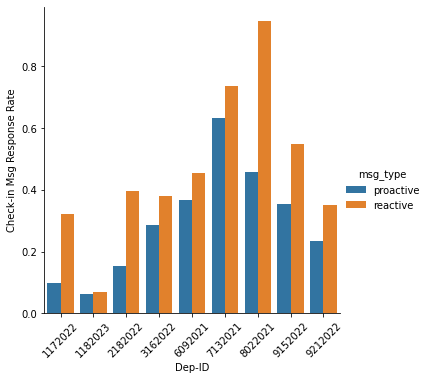

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(18, 18))

sns.catplot(
    data=data_df, kind="bar",
    x="dep_id", y="check_in_response_rate", hue="msg_type",
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
plt.xlabel("Dep-ID")
plt.xticks(rotation=45)
plt.ylabel("Check-in Msg Response Rate")
plt.show()

# g.despine(left=True)
# g.set_axis_labels("Dep-ID", "Check-in Msg Response Rate")

# g = sns.catplot(
#     data=data_df, kind="bar",
#     x="dep_id", y="check_in_response_rate", hue="msg_type",
#     # errorbar="sd", palette="dark", alpha=.6, height=6
# )
# g.despine(left=True)
# g.set_axis_labels("Dep-ID", "Check-in Msg Response Rate")

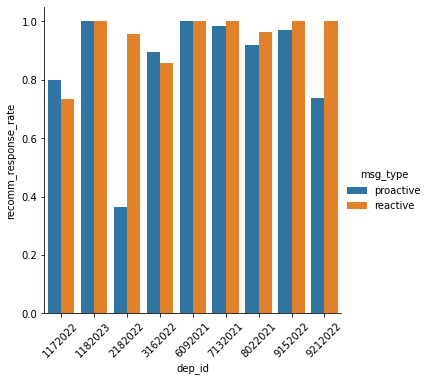

In [10]:
sns.catplot(
    data=data_df, kind="bar",
    x="dep_id", y="recomm_response_rate", hue="msg_type",
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
# g.despine(left=True)
# g.set_axis_labels("Dep-ID", "Recomm Msg Response Rate")
plt.xlabel("Dep-ID")
plt.xticks(rotation=45)
plt.ylabel("Recomm Msg Response Rate")
plt.show()

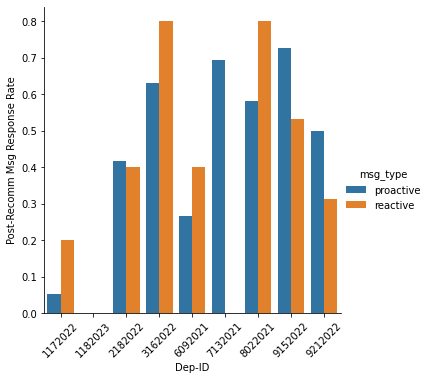

In [13]:
sns.catplot(
    data=data_df, kind="bar",
    x="dep_id", y="post_recomm_response_rate", hue="msg_type",
    # errorbar="sd", palette="dark", alpha=.6, height=6
)
# g.despine(left=True)
# g.set_axis_labels("Dep-ID", "Post-Recomm Msg Response Rate")
plt.xlabel("Dep-ID")
plt.xticks(rotation=45)
plt.ylabel("Post-Recomm Msg Response Rate")
plt.show()